In [1]:
import mne
import os.path as op
import numpy as np
from matplotlib import pyplot as plt

In [32]:
data_path = op.join('C:/Users/csilv/Desktop/UNB Gama/7 Semestre/Processamento de Sinais/Normal_Subject_01.edf') #Define data_path
raw = mne.io.read_raw_edf(data_path) #read raw data

Extracting EDF parameters from C:\Users\csilv\Desktop\UNB Gama\7 Semestre\Processamento de Sinais\Normal_Subject_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [37]:
raw.info

<Info | 16 non-empty fields
    bads : list | EMG, EMG1, EMG2, ECGII
    ch_names : list | EOG1, EOG2, EOG1A1, EOG2A1, C4A1, C3A2, F3, F4, C3, ...
    chs : list | 24 items (EEG: 24)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 128.0 Hz
    meas_date : tuple | 2015-01-26 22:56:24 GMT
    nchan : int | 24
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 256.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneTyp

In [38]:
raw.info['ch_names']

['EOG1',
 'EOG2',
 'EOG1A1',
 'EOG2A1',
 'C4A1',
 'C3A2',
 'F3',
 'F4',
 'C3',
 'C4',
 'A1',
 'A2',
 'O1',
 'O2',
 'ECGII',
 'EMG',
 'EMG1',
 'EMG2',
 'EOG1A2',
 'EOG2A2',
 'F3A2',
 'F4A1',
 'O1A2',
 'O2A1']

In [39]:
raw.info['chs'][0]['kind'] = 202
raw.info['chs'][1]['kind'] = 202
raw.info['chs'][2]['kind'] = 202
raw.info['chs'][3]['kind'] = 202
raw.info['chs'][18]['kind'] = 202
raw.info['chs'][19]['kind'] = 202

In [40]:
raw.info

<Info | 16 non-empty fields
    bads : list | EMG, EMG1, EMG2, ECGII
    ch_names : list | EOG1, EOG2, EOG1A1, EOG2A1, C4A1, C3A2, F3, F4, C3, ...
    chs : list | 24 items (EOG: 6, EEG: 18)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 128.0 Hz
    meas_date : tuple | 2015-01-26 22:56:24 GMT
    nchan : int | 24
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 256.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info :

In [41]:
raw.info['bads'] = ['EMG', 'EMG1', 'EMG2', 'ECGII']

In [42]:
picks = mne.pick_types(raw.info, eeg=True, eog= True, exclude = raw.info['bads'])

Effective window size : 8.000 (s)


<ipython-input-43-b195ff049d2b>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  without_filter = raw.plot_psd(area_mode='range', picks=picks, average=False)


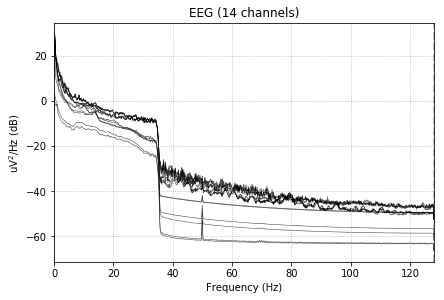

In [43]:
without_filter = raw.plot_psd(area_mode='range', picks=picks, average=False)

In [ ]:
raw.load_data()
raw.notch_filter(np.arange(50, 100, 50), picks=picks, fir_design='firwin') #notch filter at 50, 100, 150 and 200

In [ ]:
notch_filter = raw.plot_psd(area_mode='range', picks=picks, average=False, tmax=10.0)

In [ ]:
raw.filter(None, 40., picks=picks, fir_design='firwin') # low pass filtering below 40 Hz'
low_pass_filter = raw.plot_psd(area_mode='range', picks=picks, average=False, tmax=10.0)

In [ ]:
raw.filter(1., None, picks=picks, fir_design='firwin') #high pass filtering above 1Hz
high_pass_filter = raw.plot_psd(area_mode='range', picks=picks, average=False, tmax=10.0)

In [ ]:
baseline = (None) #define baseline for data
events = mne.find_events(raw) #Search for all events
epochs = mne.Epochs(raw, events, picks=picks) #Define trials